In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Numerical Estimation of Orthogonal Polynomials

Walter Gautchi (a CS professor at Purdue) had created a Fortran package (ORTHPOL) that constructs orthogonal polynomials given an arbitrary weight function.  The package is available at [here](https://www.cs.purdue.edu/homes/wxg/selected_works/section_11/141.pdf).
I have recoded the package in Python and added some additional features.

The package is based on two important theorems.
In what follows, there is a random variable $\Xi$ and we are working within the Hilbert space $L^2(\Xi)$ with the usual inner product.
The polynomials we construct are named $\pi_k(\xi)$.

**Theorem 1:**  *There is a unique set of (monic) orthogonal polynomials:*

$$
\pi_k(\xi) = \xi^k + \text{lower order terms},
$$

*satisfying:*

$$
\langle \pi_k, \pi_l \rangle = 0 \quad \text{if} \quad k \neq l.
$$

The other important theorem is the *three-term recurrence relation*.
This relation enables us to construct and evaluate the polynomials efficiently.

**Theorem 2:**  *The polynomials satisfy the three-term recurrence relation:*

$$
\pi_{k+1}(\xi) = (\xi - \alpha_k) \pi_k(\xi) - \beta_k \pi_{k-1}(\xi).
$$

*where:*

$$
\alpha_k = \frac{\langle \xi \pi_k, \pi_k \rangle}{\langle \pi_k, \pi_k \rangle}
$$

*and:*

$$
\beta_k = \frac{\langle \pi_k, \pi_k \rangle}{\langle \pi_{k-1}, \pi_{k-1} \rangle}
$$

*and:*

$$
\pi_{-1}(\xi) = 0 \quad \text{and} \quad \pi_0(\xi) = 1.
$$

Orthonormal polynomials constructed in this way are called **polynomial chaos**.
The name has nothing to do with chaos theory of dynamical systems.

## Orthojax

You will have to install the package [orthojax](https://pypi.org/project/orthojax/):

In [ ]:
!pip install orthojax

## Example: Uniform random variable on $[0, 2]$

Let $\Xi \sim U([0,2])$. The PDF is:

$$
p(\xi) = \frac{1}{2} \quad \text{for} \quad \xi \in [0,2].
$$

Here is how we can construct the polynomials:

In [2]:
import orthpol as orp

degree = 10
pdf = lambda xi: 0.5
poly = orp.make_orthogonal_polynomial(degree, left=0.0, right=2.0, wf=pdf)

Here is how the object looks like:

In [3]:
poly

OrthogonalPolynomial(
  alpha=f64[11](numpy),
  beta=f64[11](numpy),
  gamma=f64[11](numpy),
  quad=QuadratureRule(x=f32[100], w=f32[100])
)

Here are the recursion coefficients:

In [4]:
poly.alpha, poly.beta, poly.gamma

(array([1.00000012, 1.00000215, 0.9999907 , 1.0000242 , 0.99994814,
        1.00009429, 0.99984562, 1.0002358 , 0.99965942, 1.00047088,
        0.99937183]),
 array([0.99999997, 0.57734452, 0.48066709, 0.50654161, 0.4998405 ,
        0.50141765, 0.50117741, 0.50089869, 0.50129458, 0.50067245,
        0.50132882]),
 array([0.99999997, 0.57734452, 0.48066709, 0.50654161, 0.4998405 ,
        0.50141765, 0.50117741, 0.50089869, 0.50129458, 0.50067245,
        0.50132882]))

Let's plot the polynomials:

In [5]:
import numpy as np

xis = np.linspace(0.0, 2.0, 200)
phi = poly(xis)
phi.shape

(200, 11)

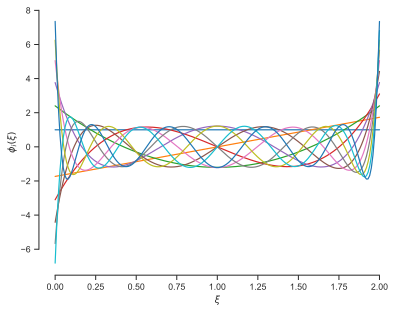

In [6]:
fig, ax = plt.subplots()
ax.plot(xis, phi)
ax.set(xlabel=r"$\xi$", ylabel=r"$\phi_i(\xi)$")
sns.despine(trim=True)

Are they really orthonormal? Let's check using a quadrature rule to calculate the required inner products.

In [7]:
# Extract collocation points and weights from the quadrature rule
x, w = poly.quad
phis = poly(x)

# Here is how we can find the norms:
norms = np.einsum("ij,i->j", phis ** 2, w)
norms

array([1.0000002 , 1.00002   , 0.99994326, 1.0001042 , 0.9998183 ,
       1.0002583 , 0.9996356 , 1.0004643 , 0.999414  , 1.000702  ,
       0.9991764 ], dtype=float32)

Pretty close to one. Let's check orthogonality:

In [8]:
for i in range(poly.num_terms):
    for j in range(i + 1, poly.num_terms):
        inner_phi_i_phi_j = np.sum(phis[:, i] * phis[:, j] * w)
        print(f"(phi_{i}, phi_{j}): {inner_phi_i_phi_j}")

(phi_0, phi_1): -2.086162567138672e-07
(phi_0, phi_2): 2.3767352104187012e-05
(phi_0, phi_3): -5.140900611877441e-06
(phi_0, phi_4): -7.689744234085083e-05
(phi_0, phi_5): 1.9162893295288086e-05
(phi_0, phi_6): 0.00015904754400253296
(phi_0, phi_7): -4.8510730266571045e-05
(phi_0, phi_8): -0.0002698153257369995
(phi_0, phi_9): 0.00010097771883010864
(phi_0, phi_10): 0.0004060771316289902
(phi_1, phi_2): -4.76837158203125e-06
(phi_1, phi_3): -4.579126834869385e-05
(phi_1, phi_4): 1.2215226888656616e-05
(phi_1, phi_5): 7.124245166778564e-05
(phi_1, phi_6): -2.5451183319091797e-05
(phi_1, phi_7): -9.632669389247894e-05
(phi_1, phi_8): 4.560500383377075e-05
(phi_1, phi_9): 0.00011873245239257812
(phi_1, phi_10): -6.803032010793686e-05
(phi_2, phi_3): 1.385807991027832e-05
(phi_2, phi_4): 0.00011909753084182739
(phi_2, phi_5): -3.6835670471191406e-05
(phi_2, phi_6): -0.00021709874272346497
(phi_2, phi_7): 7.924437522888184e-05
(phi_2, phi_8): 0.00034725572913885117
(phi_2, phi_9): -0.000144

This is pretty close to zero. We will take it.

## Example: Hermite Polynomials

Let $\Xi \sim N(0,1)$.
We can construct the polynomials like this:

In [9]:
import math

degree = 10
pdf = lambda xi: np.exp(-xi ** 2 / 2) / np.sqrt(2.0 * np.pi)
poly = orp.make_orthogonal_polynomial(degree, left=-math.inf, right=math.inf, wf=pdf)

Let's just plot them:

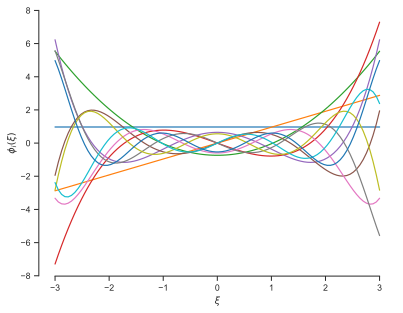

In [10]:
xis = np.linspace(-3.0, 3.0, 100)
phi = poly(xis)

fig, ax = plt.subplots()
ax.plot(xis, phi)
ax.set(xlabel=r"$\xi$", ylabel=r"$\phi_i(\xi)$")
sns.despine(trim=True)

## Example: Mixture of Gaussians

Let's do a non-trivial example where we construct orthogonal polynomials for a Gaussian mixture.
The random variable is:

$$
\Xi \sim 0.5 N(-1, 0.5^2) + 0.5 N(1, 0.5^2).
$$

The PDF is:

$$
p(\xi) = 0.5 \frac{1}{\sqrt{2 \pi} 0.5} \exp \left( - \frac{(\xi + 1)^2}{2 (0.5)^2} \right) + 0.5 \frac{1}{\sqrt{2 \pi} 0.5} \exp \left( - \frac{(\xi - 1)^2}{2 (0.5)^2} \right).
$$

Here we go:

In [11]:
degree = 10
pdf = lambda xi: 0.5 * np.exp(-(xi + 1.0) ** 2 / 2 / 0.5 ** 2) / np.sqrt(2.0 * np.pi * 0.5 ** 2) \
    + 0.5 * np.exp(-(xi - 1.0) ** 2 / 2 / 0.5 ** 2) / np.sqrt(2.0 * np.pi * 0.5 ** 2)
poly = orp.make_orthogonal_polynomial(degree, left=-math.inf, right=math.inf, wf=pdf)

And here is how the look like:

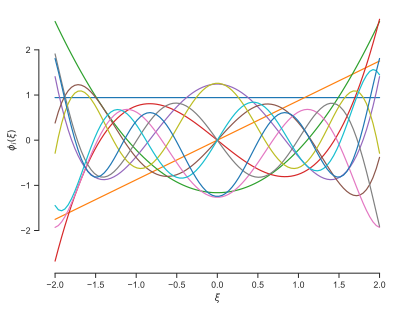

In [12]:
xis = np.linspace(-2.0, 2.0, 100)
phi = poly(xis)

fig, ax = plt.subplots()
ax.plot(xis, phi)
ax.set(xlabel=r"$\xi$", ylabel=r"$\phi_i(\xi)$")
sns.despine(trim=True)

## Example: Projecting a function onto the orthogonal basis

Let's say we have a function $f(\xi)$ and we want to project it onto the orthogonal basis.
The projection is:

$$
f(\xi) = \sum_{k=0}^n \langle f, \pi_k \rangle \pi_k(\xi).
$$

So, just need to be able to do the inner products.
Let's demonstrate with the Legendre polynomials.

In [13]:
poly = orp.make_legendre_polynomial(degree).normalize()
x, w = poly.quad

# Just a function to project
f = lambda x: np.sin(10 * x) / (10 * x)

# The projection
proj = np.einsum("i,ij,i->j", f(x), poly(x), w)
proj

array([ 1.44116715e-01,  7.56699592e-09, -1.38605773e-01, -2.59949593e-06,
        1.77557141e-01,  2.00779177e-05, -2.12554067e-01, -7.98907131e-05,
        1.24415666e-01,  1.80353876e-04, -4.03719619e-02], dtype=float32)

Let's visualize the projection:

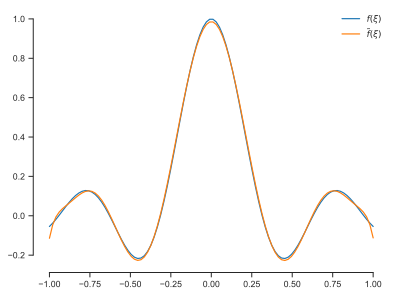

In [14]:
proj_f = lambda xi: np.einsum("k,ik->i", proj, poly(xi))

xis = np.linspace(-1.0, 1.0, 100)
fig, ax = plt.subplots()
ax.plot(xis, f(xis), label=r"$f(\xi)$")
ax.plot(xis, proj_f(xis), label=r"$\tilde{f}(\xi)$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)

Okay, pretty good.

## Example: Calculating statistics of a random variable 

Let's use the polynomial chaos expansions to calculate statistics of a random variable.

Take:

$$
\Xi \sim N(0, 1),
$$

and then:

$$
Z = f(\Xi) = \sin(10 \Xi) / (10\Xi).
$$

We want the mean and variance of $Z$.

First, we will project $f$ on the polynomial basis:

$$
f(\xi) = \sum_{k=0}^n \langle f, \pi_k \rangle \pi_k(\xi) = \sum_{k=0}^n f_k \pi_k(\xi).
$$

The mean is just the first coefficient:

$$
\mathbb{E}[Z] = \mathbb{E}[f(\Xi)] = \langle f, \pi_0 \rangle = f_0.
$$

Recall that $\pi_0 = 1$ (the constant polynomial).

The variance is:

$$
\text{Var}[Z] = \mathbb{E}[Z^2] - \mathbb{E}[Z]^2 = \sum_{k=1}^n f_k^2 - f_0^2.
$$

In [26]:
degree = 11
poly = orp.make_hermite_polynomial(degree)
x, w = poly.quad
f = lambda x: np.sin(2 * x) / (2* x)
proj = np.einsum("i,ij,i->j", f(x), poly(x), w)

mean = proj[0]
print(f"mean: {mean}")

var = np.sum(proj[1:] ** 2)
print(f"variance: {var}")

mean: 0.580583930015564
variance: 0.14914564788341522


Let's compare with the Monte Carlo estimates:

In [23]:
xis = np.random.randn(10_000)
samples = f(xis)
mc_mean = np.mean(samples)
mc_var = np.var(samples)
print(f"MC mean: {mc_mean}")
print(f"MC variance: {mc_var}")

MC mean: 0.5979364080407786
MC variance: 0.1453196265259301
